# Deep Learning Introduction (CNN Image Classification)

This notebook will contain all of the basic information I need to know in order to work with Deep Learning. I will be using Keras and Theano. Parts of the info and the code are taken from different sources.

What it Deep Learning? Deep Learning is a class of machine learning algorithms that:

• use a cascade of many layers of nonlinear processing units for feature extraction and transformation. Each successive layer uses the output from the previous layer as input. The algorithms may be supervised or unsupervised and applications include pattern analysis (unsupervised) and classification (supervised).

• are based on the (unsupervised) learning of multiple levels of features or representations of data. Higher level features are derived from lower level features to form a hierarchical representation.

• are part of the broader machine learning field of learning representations of data.

Simple oversimplification: Deep learning refers to neural networks with multiple hidden layers that can learn increasingly abstract representations of the input data.

For example, deep learning has led to major advances in computer vision. We're now able to classify images, find objects in them, and even label them with captions. To do so, deep neural networks with many hidden layers can sequentially learn more complex features from the raw input image:

• The first hidden layers might only learn local edge patterns.

• Then, each subsequent layer (or filter) learns more complex representations.

• Finally, the last layer can classify the image as a cat or kangaroo.

These types of deep neural networks are called Convolutional Neural Networks. This notebook will look at convolutional Neural Networks.

Convolutional Neural Networks (CNNs) are multi-layer neural networks (sometimes up to 20 or more layers) that assume the input data to be images.

By making this requirement, CNNs can drastically reduce the number of parameters that need to be tuned. Therefore, CNNs can efficiently handle the high dimensionality of raw images.

We will start by importing the libraries and modules needed.

Seed allows us to reproduce the results from our script:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

We will now import the Sequential model type from Keras. This is a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.

In [2]:
from keras.models import Sequential

Using Theano backend.


Now, we'll import the "core" layers from Keras. They are layers used in almost any neural network:

In [3]:
from keras.layers.core import Dense, Dropout, Activation, Flatten

Then, we import the CNN layers from Keras. There are convolutional layers that will help us efficiently train on image data:

In [4]:
from keras.layers.convolutional import Conv2D, MaxPooling2D

To help transform data, we'll import some utilities:

In [5]:
from keras.utils import np_utils

Finally, we upload the MNIST dataset, which is a handwritten digit database. We will learn from this dataset in order to predict any handwritten digit.

In [6]:
from keras.datasets import mnist

# Preprocess input data for Keras

Here we train a modernized version of the LeNet5 on the MNIST dataset.

In [7]:
batch_size = 128
nb_classes = 10 # 10 digits from 0 to 9

# input image dimensions
img_rows, img_cols = 28, 28

# Load preshuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Theano needs to know the depth (# of RGB channels) of the input images, in this case it's 1 since the images are in grayscale.

In [8]:
# X_train = X_train.reshape(X_train.shape[0] = each image in a row, 1, pixels = img_rows, pixels = img_cols)
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
print(X_train.shape)
print(X_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


The final preprocessing step for the input data is to convert our data type to float32 and normalize our data values to the range [0, 1].

In [9]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# rescaling so that the numbers are between 0 and 1
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


# Preprocess class labels for Keras

Before we can do anything with the input data, we need to make sure our class labels are split into 10 distinct class labels. If we look at the shape of our class label:

In [10]:
print(y_train.shape)

(60000,)


We have a 1-D array, which is no good because it most likely means our classes are all jumbled up together. If we look at the 10 first training examples:

In [11]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


...and so our classes are not seperated. We should convert the vector into a binary class matrix. Therefore, each seperate row will tell us which class we are in by placing a 1 in the right element and 0 in all the others in the row.

In [12]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print("Encoding: {}".format(Y_train[0:3, :]))

Encoding: [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


Looks good!

Alright, before we define the model architecture, let's visualize the images:

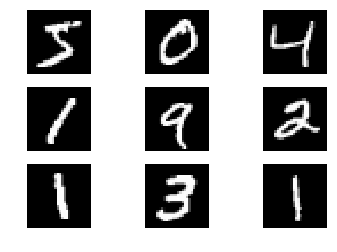

In [13]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i, 0], cmap='gray')
    plt.axis('off')

If we compare the 1s, we see that they don't exactly look the same. That's why deep learning is important because it will the structure of the 1 and it won't matter whether the 1 is tilted or not, the trained model will be able to tell if it's a 1 regardless of tilt. It's the same thing for the other numbers, but sometimes the number will be so poorly written that it will be hard for the model to distinguish which digit it is. It will choose whichever digit is more likely. That's why it is important to have a large dataset in order to learn all of the characteristics of the digits and learn all of the different ways it may be written.

# Defining the model architecture

![alt text](http://1.bp.blogspot.com/-GOQP6ia3NZY/VKjDPmD_zDI/AAAAAAAAAgk/1MBo8KSPOIo/s1600/fig1.png "CNN Deep Learning Image")

ref: http://eblearn.sourceforge.net/beginner_tutorial2_train.html

The input images are 32×32 in size with 1 channel(i.e grayscale image, not color)

From figure 1, we can say that there are 6-layers in our convnet.
1. Layer C1 is a convolution layer with 6 feature maps and a 5×5 kernel for each feature map.
2. Layer S1 is a subsampling layer with 6 feature maps and a 2×2 kernel for each feature map.
3. Layer C3 is a convolution layer with 16 feature maps and a 6×6 kernel for each feature map.
4. Layer S4 is a subsampling layer with 16 feature maps and a 2×2 kernel for each feature map.
5. Layer C5 is a convolution layer with 120 feature maps and a 6×6 kernel for each feature map.
6. Layer C6 is a fully connected layer with 84 neurons

Layer OUTPUT returns the final label

Now, we will start by declaring a sequential model format and declare the input layer:

In [21]:
model = Sequential()

# Conv2D(number_filters, row_size, column_size, input_shape=(number_channels, img_row, img_col))

model.add(Conv2D(6, (5, 5), input_shape=(1, img_rows, img_cols), padding='same')) # convolution layer
model.add(Activation('relu')) # ReLU = Rectified Linear Unit / non-linearity layer
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(120, (5, 5), data_format="channels_first"))
model.add(Activation('relu'))
model.add(Dropout(0.25))

The Dropout layer is a method to regularize the model in order to prevent overfitting.

MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

ReLU (or relu) computes the function f(x)=max(0,x). In other words, the activation is simply thresholded at zero. The function looks like this:

![alt text](http://cs231n.github.io/assets/nn1/relu.jpeg "ReLU")

There are several pros and cons to using the ReLUs:

(+) It was found to greatly accelerate (e.g. a factor of 6 in Krizhevsky et al.) the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. It is argued that this is due to its linear, non-saturating form.

(+) Compared to tanh/sigmoid neurons that involve expensive operations (exponentials, etc.), the ReLU can be implemented by simply thresholding a matrix of activations at zero.

(-) Unfortunately, ReLU units can be fragile during training and can “die”. For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be “dead” (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.

Source: http://cs231n.github.io/assets/nn1/relu.jpeg

Now, we add a fully connected layer and then the output layer:

In [22]:
model.add(Flatten()) # flatten the image

# add fully-connected layers

model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

The first parameter of the Dense layers is the output size of the layer. Keras automatically handles the connection between layers.

Note 1: The final layer has an output of 10 which corresponds to the 10 classes of digits.

Note 2: The weights from the Convolution layers must be flattened (made 1-D) before passing them to the fully-connected Dense layer.

Note 3: Softmax is a function that rescales the sum of the classes to 1 so that we can interpret the output of the matrix as a probability over the classes.

# Training the model

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [25]:
nb_epoch = 5

model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
          verbose=1, validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s - loss: 0.2443 - acc: 0.9300 - val_loss: 0.1516 - val_acc: 0.9511

# Visualize results

9/9 [==============================] - 0s


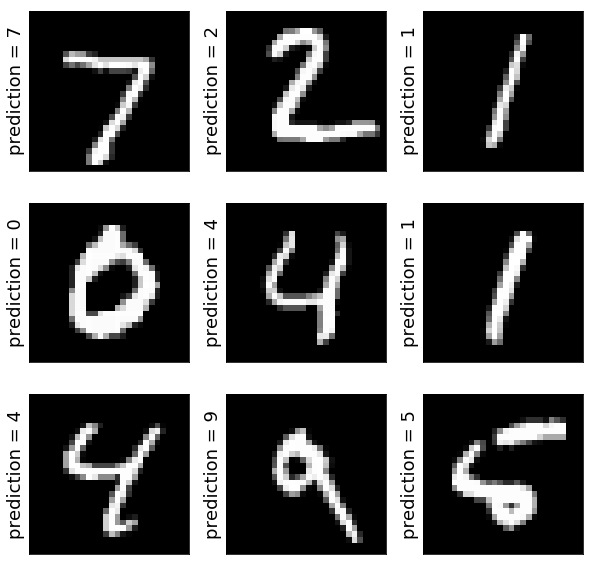

In [26]:
res = model.predict_classes(X_test[:9])
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i, 0], cmap='gray')
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel("prediction = %d" % res[i], fontsize=18)